In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class Point:
    def __init__(self,x,y, mass=1,vx=0,vy=0):
        self.x = x
        self.y = y
        self.mass = mass
        self.vx = vx
        self.vy = vy
class Rectangle:
    def __init__(self,x,y,w,h):
        # x,y = center of the Rectangle
        # w = edge to edge horizontal distance
        # h = edge to edge vertical distance
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.west_edge, self.east_edge = x - w/2, x + w/2
        self.north_edge, self.south_edge = y-h/2, y+h/2

    def contains(self,point):
        return (point.x >= self.west_edge and point.x <= self.east_edge and
        point.y >= self.north_edge and point.y <= self.south_edge)

    def intersects(self,other):
        """Does the other Rectangle object intersect with this one?"""
        return not (other.west_edge > self.east_edge or
                    other.east_edge < self.west_edge or
                    other.north_edge > self.south_edge or
                    other.south_edge < self.north_edge)

    def show(self, axis,color='black'):
        #axis.add_patch(patches.Rectangle((self.x-self.w,self.y-self.h),self.w*2,self.h*2,fill=False))
        x1, y1 = self.west_edge,self.north_edge
        x2, y2 = self.east_edge, self.south_edge
        # axis.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1], c='black', lw=1)
        axis.add_patch(patches.Rectangle((self.west_edge,self.south_edge),
        (self.east_edge-self.west_edge),
        (self.north_edge-self.south_edge),fill=False,color=color))
class Quadtree:

    def __init__(self,boundary,n = 4):

        self.boundary = boundary

        # choosing capacity(n) = 4, i.e. if particle number crosses 4 than sub-divide
        # When do i choose that i need to sub-divide
        self.capacity = n

        # Keep track of points:
        self.points = []

        self.divided = False
        self.Mass = 0
        self.CenterOfMass_x = 0
        self.CenterOfMass_y = 0

    def subdivide(self):

        x = self.boundary.x
        y = self.boundary.y
        w = self.boundary.w/2
        h = self.boundary.h/2

        ne = Rectangle(x + w/2,y - h/2, w,h)
        self.northeast = Quadtree(ne,self.capacity);
        nw = Rectangle(x - w/2,y - h/2, w,h)
        self.northwest = Quadtree(nw,self.capacity);
        se = Rectangle(x + w/2,y + h/2, w,h)
        self.southeast = Quadtree(se,self.capacity);
        sw = Rectangle(x - w/2,y + h/2, w,h)
        self.southwest = Quadtree(sw,self.capacity);

        self.divided = True

    def insert(self,point):

        # If the point isn't in the boundary then stop!
        if self.boundary.contains(point) != True:
            return False

        # Check if the number of points exceed the capacity
        if len(self.points) < self.capacity:
            # if the point does not exceed then add the point,
            # to the list of points in the boundary
            self.points.append(point)
            return True
        # If the number of points exceed the given capacity then
        # subdivide the rectangular boundary into four parts

        # subdivide boundary
        if not self.divided:
            self.subdivide()

        return (self.northeast.insert(point) or
        self.northwest.insert(point) or
        self.southeast.insert(point) or
        self.southwest.insert(point))


    def query(self, boundary, found_points):
        """Find points in the quadtree that lie within a boundary."""
        if not self.boundary.intersects(boundary):
            # if the domain of this node does not interesect the search
            # region, we don't need to look in it for points.
            return False

        # Search this node's point to see if they lie within boundary
        for point in self.points:
            if boundary.contains(point):
                found_points.append(point)
        # if this node has children, search them too.
        if self.divided:
            self.northeast.query(boundary,found_points)
            self.northwest.query(boundary,found_points)
            self.southeast.query(boundary,found_points)
            self.southwest.query(boundary,found_points)
        return found_points

    def compute_mass_distribution(self):

        if not self.divided:
            for i in range(len(self.points)):
                self.CenterOfMass_x += self.points[i].x*self.points[i].mass
                self.CenterOfMass_y += self.points[i].y*self.points[i].mass
                self.Mass += self.points[i].mass
            return self.Mass, self.CenterOfMass_x/self.Mass, self.CenterOfMass_y/self.Mass

        else:
            # Compute the center of mass based on the masses
            # of all child quadrants and the center of mass as
            # the center of mass of the child quadrants weights with their mass

            ne_mass,ne_com_x,ne_com_y = self.northeast.compute_mass_distribution()
            nw_mass,nw_com_x,nw_com_y = self.northwest.compute_mass_distribution()
            se_mass,se_com_x,se_com_y = self.southeast.compute_mass_distribution()
            sw_mass,sw_com_x,sw_com_y = self.southwest.compute_mass_distribution()
            self.Mass = ne_mass + nw_mass + se_mass + sw_mass
            self.CenterOfMass_x = ne_mass*ne_com_x + nw_mass*nw_com_x + se_mass*se_com_x + sw_mass*se_com_x
            self.CenterOfMass_y = ne_mass*ne_com_y + nw_mass*nw_com_y + se_mass*se_com_y + sw_mass*se_com_y

            return self.Mass, self.CenterOfMass_x/self.Mass, self.CenterOfMass_y/self.Mass

    def distance(self,x1,y1,x2,y2):
        return (np.sqrt((x2-x1)**2 + (y2-y1)**2))

    def calculate_force(self, point,G=0.1,theta=1.1):
        """
        Call this function for each particle in each time step.
        for example:
            for particle in num_of_particles:
                calculate_force(particle, G, theta)"""
        force = 0
        acc_x = 0
        acc_y = 0
        if len(self.points) <=self.capacity and len(self.points)!=0:
            for i in range(len(self.points)):
                if self.points[i].x != point.x and self.points[i].y != point.y:
                    x_dist = self.points[i].x - point.x
                    y_dist = self.points[i].y - point.y
                    Rsq = x_dist**2 + y_dist**2

                    a = G*self.points[i].mass/Rsq
                    acc_x += a * x_dist/np.sqrt(Rsq)
                    acc_y += a * y_dist/np.sqrt(Rsq)
            return acc_x, acc_y

        else:
                mass_node, r_x,r_y = self.compute_mass_distribution()
                x_dist = r_x - point.x
                y_dist = r_y - point.y
                r = np.sqrt(x_dist**2 + y_dist**2)
                d = abs(self.north_edge - self.south_edge)
                if d/r <theta:
                    force += G*point.mass*mass_node/r**2
                else:
                    # Compute force on child node
                    if self.divided:
                        self.northwest.calculate_force(self, point)
                        self.northeast.calculate_force(self, point)
                        self.southwest.calculate_force(self, point)
                        self.southeast.calculate_force(self, point)
        acc = force/point.mass
        dist = np.sqrt((point.x-self.CenterOfMass_x)**2+(point.y-self.CenterOfMass_y)**2)
        acc_x = acc*abs(point.x - self.CenterOfMass_x)/dist
        acc_y = acc*abs(point.y - self.CenterOfMass_y)/dist
        return acc_x, acc_y

    def step(self,all_points,dt=0.1,G=0.1,theta=1.1):
        """This function updates the position of the point w.r.t
        all other particles
        all_points: list of all Point objects"""

        for point in all_points:
            point.x = point.x + point.vx*dt
            point.y = point.y + point.vy*dt

            acc_x, acc_y = self.calculate_force(point,G,theta)
            point.vx = point.vx + acc_x*dt
            point.vy = point.vy + acc_y*dt
        return all_points


    def show(self,axis):
        self.boundary.show(axis)
        if self.divided:
            self.northeast.show(axis)
            self.northwest.show(axis)
            self.southeast.show(axis)
            self.southwest.show(axis)


c:\users\astro\appdata\local\programs\python\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\astro\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\users\astro\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


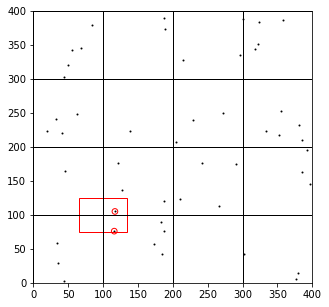

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle as rect
import utils
fig, ax = plt.subplots(figsize=(5,5))

# specs of Rectangle:
width = 400
height = 400
center_x = 200
center_y = 200
boundary = Rectangle(center_x,center_y,width,height)
qt = Quadtree(boundary, 4)

for i in range(50):
    x = np.random.randint(0,400)
    y = np.random.randint(0,400)
    mass = np.random.randint(3,500)
    p = Point(x,y,mass)
    ax.scatter(p.x,p.y,s=1,c='black')
    qt.insert(p)

# give me points in this region
region = Rectangle(100,100,68,50)
found_points = []
qt.query(region,found_points)
ax.scatter([p.x for p in found_points],[p.y for p in found_points],
facecolors='none', edgecolors='r',s=32)
region.show(ax,color='red')
ax.set_xlim(center_x-width/2,center_x+width/2)
ax.set_ylim(center_y-height/2,center_y+height/2)

qt.show(ax)
plt.show()


In [3]:
# Function to scale masses for their sizes
def scale_the_array(arr, min_=7, max_=300):
    l = []
    for element in arr:
        if arr.max() != arr.min():
            scaled_element = ((element - arr.min())/(arr.max()-arr.min()))*(max_-min_) + min_
            l.append(scaled_element)
        else:
            # Default size
            l = [20, 20]
            
    return np.array(l)

In [4]:
from IPython.display import clear_output

KeyboardInterrupt: 

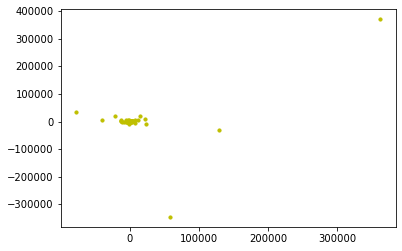

In [5]:
# masses
masses = np.array([100000, 950, 500])


# Initial x positions
x0 = np.array([200,150, 200])
# Initial y positions
y0 = np.array([200, 175, 0])
# Initial  
vx0 = np.array([0, 10, -5])
vy0 = np.array([0, -30, 12])
points = []

# specs of Rectangle:
width = 400
height = 400
center_x = 200
center_y = 200
boundary = Rectangle(center_x,center_y,width,height)
qt = Quadtree(boundary, 4)

for i in range(300):
    x = np.random.randint(0,400)
    y = np.random.randint(0,400)
    vx = np.random.randint(-10,10)
    mass = np.random.randint(400,10000)
    points.append(Point(x,y,mass=mass,vx=vx))


# Calling the function to scale masses to determine its size.
scaled_masses = scale_the_array(masses) 

# fig, ax = plt.subplots()
for time in range(300):
    for p in points:
        plt.scatter(p.x, p.y, c='y', s=10)
        qt.insert(p)
    points = qt.step(points,dt=0.9, G=1,theta=0.7)
    
    #qt.show(ax)
    plt.xlim(0, 400)
    plt.ylim(0, 400)
    plt.show()
    print(f"frame: {time}/300")    
    clear_output(wait=True)


